# 遥感图像分类 baseline 

### 本baseline采用PyTorch框架，应用ModelArts的Notebook进行开发

### 数据集获取

In [15]:
import moxing as mox
mox.file.copy_parallel('obs://obs-aigallery-zc/clf/code/Remote_Sensing_Image_classification/model', 'model')
mox.file.copy_parallel('obs://obs-aigallery-zc/clf/code/Remote_Sensing_Image_classification/data', 'data')
print("done")

INFO:root:Listing OBS: 1000

INFO:root:Listing OBS: 2000

INFO:root:Listing OBS: 3000

INFO:root:Listing OBS: 4000

INFO:root:Listing OBS: 5000

INFO:root:1000/5304

INFO:root:2000/5304

INFO:root:3000/5304

INFO:root:4000/5304

INFO:root:5000/5304


done


### 加载依赖

In [1]:

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os


### 加载数据集，并将其分为训练集和测试集

In [2]:
dataTrans = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
        ])
 
    # image data path
data_dir = './data'
all_image_datasets = datasets.ImageFolder(data_dir, dataTrans)
print(all_image_datasets.class_to_idx)    
trainsize = int(0.8*len(all_image_datasets))
testsize = len(all_image_datasets) - trainsize
train_dataset, test_dataset = torch.utils.data.random_split(all_image_datasets,[trainsize,testsize])
   
image_datasets = {'train':train_dataset,'val':test_dataset}
    

    # wrap your data and label into Tensor

    
dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                 batch_size=64,
                                                 shuffle=True,
                                                 num_workers=4) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    # use gpu or not
use_gpu = torch.cuda.is_available()

{'agricultural': 0, 'airplane': 1, 'baseballdiamond': 2, 'beach': 3, 'buildings': 4, 'chaparral': 5, 'denseresidential': 6, 'forest': 7, 'freeway': 8, 'golfcourse': 9, 'harbor': 10, 'intersection': 11, 'mediumresidential': 12, 'mobilehomepark': 13, 'overpass': 14, 'parkinglot': 15, 'river': 16, 'runway': 17, 'sparseresidential': 18, 'storagetanks': 19, 'tenniscourt': 20}


In [3]:
def train_model(model, lossfunc, optimizer, scheduler, num_epochs=10):
    start_time = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data.
            for data in dataloders[phase]:
                # get the inputs
                inputs, labels = data
                

                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = lossfunc(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.data
                running_corrects += torch.sum(preds == labels.data).to(torch.float32)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    elapsed_time = time.time() - start_time
    print('Training complete in {:.0f}m {:.0f}s'.format(
        elapsed_time // 60, elapsed_time % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
  
    return model

### 模型训练
采用resnet50神经网络结构训练模型,模型训练需要一定时间，等待该段代码运行完成后再往下执行。

In [4]:
# get model and replace the original fc layer with your fc layer
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 21)

if use_gpu:
    model_ft = model_ft.cuda()

    # define loss function
lossfunc = nn.CrossEntropyLoss()

    # setting optimizer and trainable parameters
 #   params = model_ft.parameters()
 # list(model_ft.fc.parameters())+list(model_ft.layer4.parameters())
#params = list(model_ft.fc.parameters())+list( model_ft.parameters())
params = list(model_ft.fc.parameters())
optimizer_ft = optim.SGD(params, lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model=model_ft,
                           lossfunc=lossfunc,
                           optimizer=optimizer_ft,
                           scheduler=exp_lr_scheduler,
                           num_epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ma-user/.cache/torch/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch 0/9

----------


/home/ma-user/anaconda3/envs/PyTorch-1.4/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.0344 Acc: 0.4907

val Loss: 0.0238 Acc: 0.7125

Epoch 1/9

----------

train Loss: 0.0198 Acc: 0.7570

val Loss: 0.0159 Acc: 0.7945

Epoch 2/9

----------

train Loss: 0.0145 Acc: 0.8249

val Loss: 0.0125 Acc: 0.8501

Epoch 3/9

----------

train Loss: 0.0117 Acc: 0.8543

val Loss: 0.0105 Acc: 0.8662

Epoch 4/9

----------

train Loss: 0.0100 Acc: 0.8793

val Loss: 0.0090 Acc: 0.8935

Epoch 5/9

----------

train Loss: 0.0089 Acc: 0.8991

val Loss: 0.0082 Acc: 0.9057

Epoch 6/9

----------

train Loss: 0.0082 Acc: 0.9069

val Loss: 0.0080 Acc: 0.9039

Epoch 7/9

----------

train Loss: 0.0081 Acc: 0.9071

val Loss: 0.0079 Acc: 0.9057

Epoch 8/9

----------

train Loss: 0.0080 Acc: 0.9097

val Loss: 0.0080 Acc: 0.9057

Epoch 9/9

----------

train Loss: 0.0079 Acc: 0.9121

val Loss: 0.0079 Acc: 0.9039

Training complete in 4m 13s

Best val Acc: 0.905749


将训练好的模型保存下来。

In [5]:
torch.save(model_ft.state_dict(), './model/model.pth')

## 模型测试

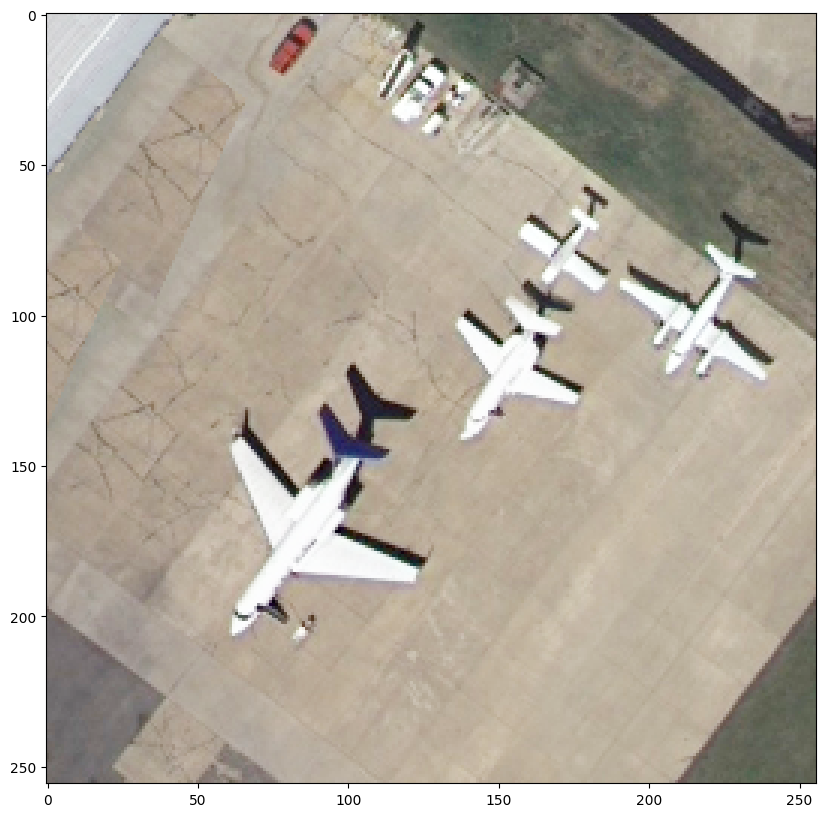

{'logits': {'agricultural': 0.002, 'airplane': 0.736, 'baseballdiamond': 0.012, 'beach': 0.037, 'buildings': 0.029, 'chaparral': 0.002, 'denseresidential': 0.009, 'forest': 0.0, 'freeway': 0.006, 'golfcourse': 0.004, 'harbor': 0.042, 'intersection': 0.013, 'mediumresidential': 0.008, 'mobilehomepark': 0.006, 'overpass': 0.009, 'parkinglot': 0.015, 'river': 0.003, 'runway': 0.019, 'sparseresidential': 0.012, 'storagetanks': 0.027, 'tenniscourt': 0.009}}


In [10]:

from math import exp
import numpy as np

from PIL import Image
import cv2



infer_transformation = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])


IMAGES_KEY = 'images'
MODEL_INPUT_KEY = 'images'
MODEL_OUTPUT_KEY = 'logits'
LABELS_FILE_NAME = 'labels_21c.txt'


def decode_image(file_content):
    image = Image.open(file_content)
    image = image.convert('RGB')
    return image

 
def read_label_list(path):

    with open(path, 'r',encoding="utf8") as f:
        label_list = f.read().split(os.linesep)
    label_list = [x.strip() for x in label_list if x.strip()]
    return label_list


def resnet50(model_path):

    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = models.resnet50(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 21)
    model.load_state_dict(torch.load(model_path,map_location ='cpu'))
    # model.load_state_dict(torch.load(model_path))

    model.eval()

    return model


def predict(file_name):
    LABEL_LIST = read_label_list('./model/labels_21c.txt')
    model = resnet50('./model/model.pth')
    
    image1 = decode_image(file_name)
    

    input_img = infer_transformation(image1)

    input_img = torch.autograd.Variable(torch.unsqueeze(input_img, dim=0).float(), requires_grad=False)

    logits_list =  model(input_img)[0].detach().numpy().tolist()
    maxlist=max(logits_list)

    z_exp = [exp(i-maxlist) for i in  logits_list]

    sum_z_exp = sum(z_exp)
    softmax = [round(i / sum_z_exp, 3) for i in z_exp]

    labels_to_logits = {
        LABEL_LIST[i]: s for i, s in enumerate(softmax)
    }
    
    predict_result = {
        MODEL_OUTPUT_KEY: labels_to_logits
    }

    return predict_result

# file_name = './data/mediumresidential/mediumresidential_105.jpg'
file_name = './data/airplane/airplane00.tif'
result = predict(file_name)  #可以替换其他图片
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10)) #设置窗口大小
img = decode_image(file_name)
plt.imshow(img)
plt.show()

print(result)

可以看到预测结果里，airplane的概率为0.736，模型预测成功

### 将训练好的模型导入ModelArts
将模型导入ModelArts，为后续推理测试、模型提交做准备。


In [13]:
from modelarts.session import Session
from modelarts.model import Model
from modelarts.config.model_config import TransformerConfig,Params
!pip install json5
import json5
import re
import traceback
import random

try:
    session = Session()
    config_path = 'model/config.json' 
    if mox.file.exists(config_path):                                        # 判断一下是否存在配置文件，如果没有则不能导入模型
        model_location =  './model'
        model_name = "image_classification"
        load_dict = json5.loads(mox.file.read(config_path))
        model_type = load_dict['model_type']
        re_name = '_'+str(random.randint(0,1000))
        model_name += re_name
        print("正在导入模型,模型名称：", model_name)
        model_instance = Model(
                     session, 
                     model_name=model_name,               # 模型名称
                     model_version="1.0.0",               # 模型版本
                      source_location_type='LOCAL_SOURCE',
                     source_location=model_location,      # 模型文件路径
                     model_type=model_type,               # 模型类型
                     )

    print("所有模型导入完成")
except Exception as e:
    print("发生了一些问题，请看下面的报错信息：") 
    traceback.print_exc()
    print("模型导入失败")

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple


正在导入模型,模型名称： image_classification_708

modelarts-cn-north-4-72b6beb2 is existed


INFO:obs:Successfully upload file /home/ma-user/work/2021hwjx-baseline/model/.ipynb_checkpoints to OBS modelarts-cn-north-4-72b6beb2/model-1031-223150/model

INFO:obs:Successfully upload file /home/ma-user/work/2021hwjx-baseline/model/.ipynb_checkpoints to OBS modelarts-cn-north-4-72b6beb2/model-1031-223150/model

INFO:obs:Successfully upload file /home/ma-user/work/2021hwjx-baseline/model to OBS modelarts-cn-north-4-72b6beb2/model-1031-223150

INFO:obs:Successfully upload file /home/ma-user/work/2021hwjx-baseline/model to OBS modelarts-cn-north-4-72b6beb2/model-1031-223150

INFO:obs:Successfully upload file /home/ma-user/work/2021hwjx-baseline/model to OBS modelarts-cn-north-4-72b6beb2/model-1031-223150

INFO:obs:Successfully upload file /home/ma-user/work/2021hwjx-baseline/model to OBS modelarts-cn-north-4-72b6beb2/model-1031-223150


Successfully upload file /home/ma-user/work/2021hwjx-baseline/model to OBS modelarts-cn-north-4-72b6beb2/model-1031-223150

Successfully upload model files from /home/ma-user/work/2021hwjx-baseline/model to obs path /modelarts-cn-north-4-72b6beb2/model-1031-223150.

The model source location is https://modelarts-cn-north-4-72b6beb2.obs.cn-north-4.myhuaweicloud.com/model-1031-223150/model

publishing

published

所有模型导入完成
